In [15]:
#import mtcnn, facenet and pinecone
!pip3 install mtcnn keras-facenet pinecone --upgrade pinecone-client python-dotenv opencv-python scipy scikit-learn 

  Using cached pinecone_client-5.0.1-py3-none-any.whl.metadata (19 kB)


In [16]:
import os
from dotenv import load_dotenv , dotenv_values
load_dotenv()
os.environ["PINECONE_API_KEY"] = os.getenv("pinecone_key")
os.environ["PINECONE_IDX"] = os.getenv("pinecone_index")

In [17]:
# Get Face Encodings of Faces in Database

In [18]:
import numpy as np
from mtcnn import MTCNN
import os
import scipy # for MTCNN Dependencies
from keras_facenet import FaceNet
import cv2
detector = MTCNN()
embedder = FaceNet()

In [69]:
def get_embedding(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  try:
    faces = detector.detect_faces(img)[0]
    x1, y1, width, height = faces['box']
    x1, y1 = abs(x1), abs(y1)
    img = img[y1:y1+height, x1:x1+width]
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    print(f"Detected Face in {file}")
    return embedder.embeddings(img)[0]
  except:
    print(f"Failed to detect faces in {file}")
    return None

In [20]:
def make_embeddings(dir):
  embeddings = {}
  for file in os.listdir(dir):
    emb = get_embedding('/content/faces/' + file)
    if emb is not None:
      embeddings[file.split('.')[0]] = emb
    else:
      os.remove('/content/faces/' + file)
  return embeddings

In [21]:
def make_meta(file , i):
  meta = {'image_id':f"Image_{i}"}
  meta['label'] = os.path.splitext(file)[0]
  return meta

In [11]:
from pinecone import Pinecone
pc = Pinecone(os.environ["PINECONE_API_KEY"])
index = pc.Index(os.environ["PINECONE_IDX"])

In [12]:
def upsert_embeddings(face_embeddings , metadata):
  assert len(face_embeddings) == len(metadata) , 'Inssuficient data in input vectors'
  assert face_embeddings is not None and metadata is not None , 'Input vectors cannot be None'
  assert face_embeddings[0].shape[0] == index.describe_index_stats()['dimension'] , 'Dimension mismatch'
  a = index.describe_index_stats()['total_vector_count'] + 1
  upsert_data = [(str(i + a), face_embeddings[i].tolist(), metadata[i]) for i in range(len(face_embeddings))] # index starts from last vector in database
  index.upsert(vectors=upsert_data)
  return True

In [13]:
def fetch_embeddings(embeddings):
  assert embeddings.shape[0] == index.describe_index_stats()['dimension'] , 'Dimension mismatch'
  assert embeddings is not None , 'Input vectors cannot be None'

  out = index.query(
      vector=embeddings.tolist(),
      top_k=1,
      include_metadata=True
  )
  name , confidence = out['matches'][0]['metadata']['label'] , out['matches'][0]['score']
  return name , confidence

In [14]:
def multiple_faces(file):
  imga = cv2.imread(file)
  imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
  try:
    faces = detector.detect_faces(imga)
    embs = []
    boxes = []
    for face in faces:
      x1, y1, width, height = face['box']
      x1, y1 = abs(x1), abs(y1)
      img = imga[y1:y1+height, x1:x1+width]
      img = cv2.resize(img, (224, 224))
      img = np.expand_dims(img, axis=0)
      embs.append(embedder.embeddings(img)[0])
      boxes.append([x1, y1, width, height])
    return embs, boxes
  except Exception as e:
      print(f"Failed to detect faces in {file} due to {e}")
  return None

In [15]:
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
def draw_boxes(file, boxes ,labels, probs , mode = True):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for box , label , prob in zip(boxes,labels, probs):
    x1, y1, width, height = box
    img = cv2.rectangle(img, (x1, y1), (x1+width, y1+height), (0, 255, 0), 1)
    if label == 'Unknown':
      img = cv2.putText(img, f"{label}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    else:
      img = cv2.putText(img, f"{label} {np.round(prob , decimals = 2)}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  try:
    if mode:
      cv2.imshow('detections', img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
    else: # due to cv2 imshow errors on macos use plt for imshow by putting mode = False
      plt.figure(figsize = (10,15))
      img = img[:,:,::-1]
      plt.imshow(img)
  except:
    cv2_imshow(img) #for colab notebooks uncomment above to import colab version of cv2_imshow
  return None

In [16]:
def write_and_upsert(dir , upsert = False):
  embeddings = make_embeddings(dir)
  metadata = [make_meta(file, i) for i, file in enumerate(embeddings.keys())]
  if upsert:
    upsert_embeddings(list(embeddings.values()), metadata)

In [17]:
def detect_and_fetch(dir , directory = True , min_confidence = 0 , mode = True):
  if directory:
    files = [os.path.join(dir , i) for i in os.listdir(dir)]
    print(files)
  else:
    files = []
    files.append(dir)
  for file in files:
    try:
      embs , boxes = multiple_faces(file)
      labels = []
      probs = []
      for emb in embs:
        name , confidence = fetch_embeddings(emb)
        if confidence > min_confidence:
          labels.append(name)
          probs.append(confidence)
        else:
          labels.append('Unknown')
          probs.append('unk')
      draw_boxes(file, boxes, labels, probs , mode)
    except Exception as e:
      print(f"Failed to detect faces in {file} due to {e}")
  return True

In [18]:
#write_and_upsert('/content/faces' , upsert = True)

['/Users/aditya/Desktop/Face Recognition/test/test-2.jpeg', '/Users/aditya/Desktop/Face Recognition/test/Test_image.jpeg', '/Users/aditya/Desktop/Face Recognition/test/test-1.jpeg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


2024-08-04 22:15:24.210124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/stepWARNING:tensorflow:5 out of the last 18 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31e344d60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to htt

True

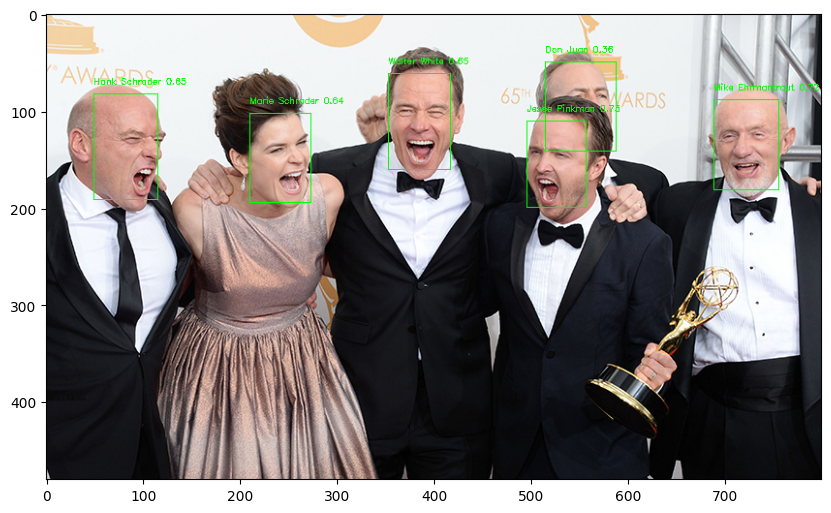

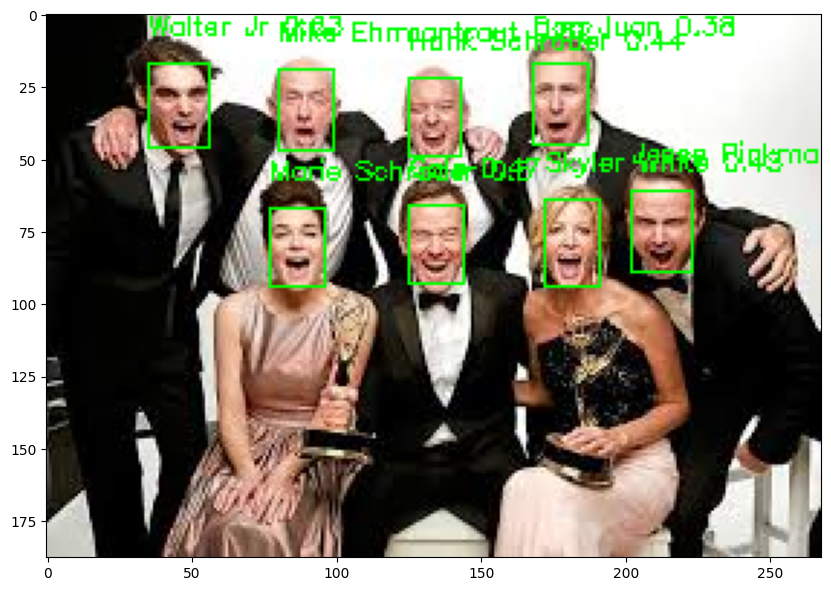

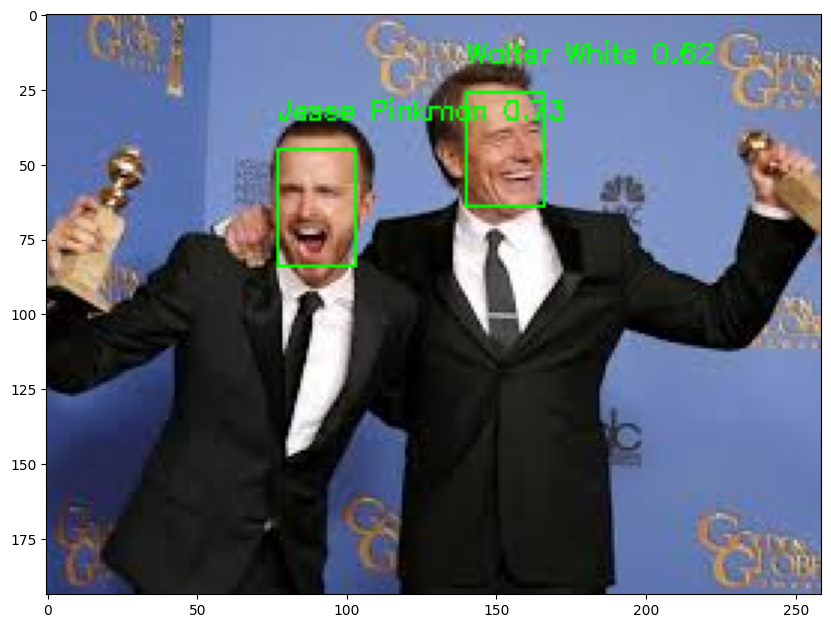

In [19]:
detect_and_fetch('/Users/aditya/Desktop/Face Recognition/test' ,mode=False)

In [110]:
# with confidence threshold

['/content/test/.ipynb_checkpoints', '/content/test/test-1.jpeg', '/content/test/test-2.jpeg', '/content/test/Test_image.jpeg']
Failed to detect faces in /content/test/.ipynb_checkpoints due to OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


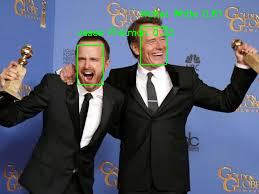

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


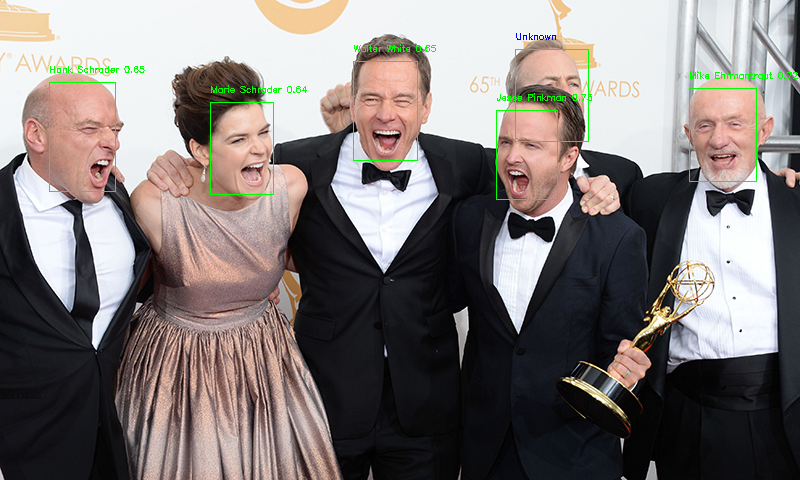

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


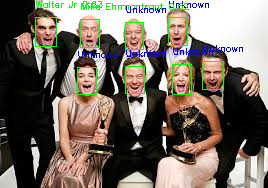

True

In [29]:
detect_and_fetch('/content/test' , min_confidence=0.5)